In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import glob
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import linear_model
from scipy import stats
import matplotlib.pyplot as plt
from tensorflow import keras
from skimage.transform import resize
import matplotlib.patches as patches
from keras.models import Sequential
from scipy.stats.stats import pearsonr
from scipy.ndimage.filters import gaussian_filter as gf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

from hyss_util import *

2023-08-07 19:45:07.700334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 19:45:07.833780: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-07 19:45:08.265492: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-07 19:45:08.265547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [27]:
plt.style.use("bmh")

# -- set grayscale to be the default color map
plt.rcParams["image.cmap"] = "gist_gray"
plt.rcParams["axes.grid"] = False
plt.rcParams["figure.figsize"] = (15, 8)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams['axes.titlepad'] = 0 

In [4]:
# -- load 2013 and 2015 images
imgL_hsi0 = np.load("../output/graham_hall_upload/imgL0_overlap.npy")
imgL_hsi1 = np.load("../output/img_L1_fnl.npy")

# -- load waves range for both scans
waves0 = np.load("../output/graham_hall_upload/cube0_waves_range.npy")
waves1 = np.load("../output/graham_hall_upload/cube1_waves_range.npy")

In [5]:
# -- 1D-CNN MODEL
# -- load source spectra and type for both hsi0 and hsi1
cnn_hsi0 = np.load("../output/graham_hall_upload/hsi0spec_labeled.npy", allow_pickle=True)
cnn_hsi1 = np.load("../output/graham_hall_upload/hsi1spec_labeled.npy", allow_pickle=True)

# -- targ
targ_hsi0 = np.load("../output/graham_hall_upload/hsi0_labeled_targ.npy", allow_pickle=True)
targ_hsi1 = np.load("../output/graham_hall_upload/hsi1_labeled_targ.npy", allow_pickle=True)

# -- location
loc_hsi0 = np.load("../output/upload_to_dfam/hsi0spec_loc_all.npy")
loc_hsi1 = np.load("../output/upload_to_dfam/hsi1spec_location_all.npy")

In [6]:
spec_loc_hsi0 = pd.DataFrame(loc_hsi0)
spec_loc_hsi0["targ"] = targ_hsi0
spec_loc_hsi0["targ"] = spec_loc_hsi0["targ"].replace("unknown", "Unknown")

spec_loc_hsi0.rename({0: 'y', 1: 'x'}, axis=1, inplace=True)
spec_loc_hsi0

,y,x,targ
0,205.0,407.0,LED
1,211.0,407.0,LED
2,222.0,407.0,LED
3,222.0,408.0,LED
4,229.0,407.0,LED
...,...,...,...
708,641.0,661.0,Incandescent
709,642.0,661.0,Incandescent
710,667.0,577.0,Incandescent
711,676.0,833.0,Incandescent


In [7]:
spec_loc_hsi1 = pd.DataFrame(loc_hsi1)
spec_loc_hsi1["targ"] = targ_hsi1
spec_loc_hsi1["targ"] = spec_loc_hsi1["targ"].replace("unknown", "Unknown")

spec_loc_hsi1.rename({0: 'y', 1: 'x'}, axis=1, inplace=True)
spec_loc_hsi1

,y,x,targ
0,174.0,137.0,LED
1,174.0,146.0,LED
2,174.0,147.0,LED
3,175.0,138.0,LED
4,178.0,139.0,LED
...,...,...,...
611,511.0,148.0,Incandescent
612,519.0,157.0,Incandescent
613,547.0,227.0,Incandescent
614,672.0,214.0,Incandescent


In [8]:
# # -- create five categories
def creat_cates(hsi):

  INC = hsi[hsi["targ"].str.contains("Incandescent")]
  HPS = hsi[hsi["targ"].str.contains("High_Pressure_Sodium")]
  LED = hsi[hsi["targ"].str.contains("LED")]
  CFL = hsi[hsi["targ"].str.contains("Fluorescent")]
  MH = hsi[hsi["targ"].str.contains("Metal_Halide")]
  Unknown = hsi[hsi["targ"].str.contains("Unknown")]

  return INC, HPS, LED, CFL, MH, Unknown

In [9]:
# -- interpolate the hsi0 spectra 
cnn_hsi0_inter = np.empty((len(cnn_hsi0), len(waves1)))
for i in range(0, len(cnn_hsi0)):
    interp = np.interp(waves1, waves0, cnn_hsi0[:, :872][i])
    cnn_hsi0_inter[i,:] = (interp)


# -- interpolate the wavelengths of the HSI scan
cnn_hsi1_spec = cnn_hsi1[:, :848]

In [10]:
INC_label_hsi0, HPS_label_hsi0, LED_label_hsi0, CFL_label_hsi0, MH_label_hsi0, Unknown_label_hsi0 = creat_cates(spec_loc_hsi0)
INC_label_hsi1, HPS_label_hsi1, LED_label_hsi1, CFL_label_hsi1, MH_label_hsi1, Unknown_label_hsi1 = creat_cates(spec_loc_hsi1)

In [11]:
# -- normlize raw data 
def norm(feat):

  """
  Read source spectra

  Parameters:
  ----------
  feat: a two dimentional array of source spectra

  Returns:
  -------
  a two dimentional array
  normlized source spectra
  
  """
  feat_norm = np.empty(feat.shape)
  for i in range(0, len(feat)):
    norm = (feat[i] - feat[i].min()) / (feat[i].max() - feat[i].min())
    feat_norm[i, :] = norm
  return feat_norm

cnn_hsi1_spec_norm = norm(cnn_hsi1_spec)
cnn_hsi0_spec_norm = norm(cnn_hsi0_inter)


# -- combine both scans' feature 
feat = np.vstack([cnn_hsi0_spec_norm, cnn_hsi1_spec_norm])

In [12]:
# -- get target  
target_hsi1 = targ_hsi1.astype(str)
target_hsi0 = targ_hsi0.astype(str)

# -- hsi1
target_dict = {'High_Pressure_Sodium': 0,'LED': 1, 'Fluorescent': 2,'Metal_Halide': 3, 'Incandescent': 4, "Unknown" :5 }
target_hsi1 = np.array([target_dict[item] for item in target_hsi1]).astype("int")
target_hsi1

# -- hsi0
target_hsi0 = np.array([target_dict[item] for item in target_hsi0]).astype("int")
target_hsi0

# -- combine both scans' target
target = np.concatenate([target_hsi0, target_hsi1])
target.shape

(1329,)

In [13]:
# -- combine the locations
loc_all = np.vstack([loc_hsi0, loc_hsi1])

# -- add locations to all spectra
feat_loc = np.hstack([feat, loc_all])

# --add locations to each image
cnn_hsi0_spec_norm_loc = np.hstack([cnn_hsi0_spec_norm, loc_hsi0])
cnn_hsi1_spec_norm_loc = np.hstack([cnn_hsi1_spec_norm, loc_hsi1])

In [14]:
# -- add target to each image
hsi1 = pd.DataFrame(cnn_hsi1_spec_norm_loc).rename(columns=str)
hsi1["target"] = target_hsi1


hsi0 = pd.DataFrame(cnn_hsi0_spec_norm_loc).rename(columns=str)
hsi0["target"] = target_hsi0

In [15]:
# -- create a training and testing set
feature = feat_loc
targ = target

feat_tr, feat_te, targ_tr, targ_te = train_test_split(feature, targ, test_size=0.2, random_state=302)

# -- check the shapes of the data
print("training set shape : ", feat_tr.shape)
print("testing set shape  : ", feat_te.shape)

training set shape :  (1063, 850)
testing set shape  :  (266, 850)


In [16]:
# -- finding the testing data in hsi0 and hsi1 image
feat_te_df = pd.DataFrame(feat_te).rename(columns=str)

# -- for hsi0
hsi0_te = hsi0.merge(feat_te_df, on=["100", "200", "300", "400", "500", "600", "700", "848","849"],how='left', indicator=True)
hsi0_te = hsi0_te[hsi0_te["_merge"] == "both"]
hsi0_te_spec = np.array(hsi0_te)[:, :848].astype('float64')
hsi0_te_targ = np.array(hsi0_te)[:, 850].astype('int64')


# -- for hsi1
hsi1_te = hsi1.merge(feat_te_df, on=["100", "200", "300", "400", "500", "600", "700", "848","849"],
                   how='left', indicator=True)
hsi1_te = hsi1_te[hsi1_te["_merge"] == "both"]
hsi1_te_spec = np.array(hsi1_te)[:, :848].astype('float64')
hsi1_te_targ = np.array(hsi1_te)[:, 850].astype('int64')

In [17]:
# -- reshape the training and testing data
feat_tr_spec = feat_tr[:, :848]
feat_tr_spec = feat_tr_spec.reshape(feat_tr_spec.shape[0], 848, 1)

hsi0_te_spec = hsi0_te_spec.reshape(hsi0_te_spec.shape[0], 848, 1)
hsi1_te_spec = hsi1_te_spec.reshape(hsi1_te_spec.shape[0], 848, 1)

In [18]:
# -- Testing data in this model are the spectra come from both scans
# -- the testing data in this model are the spectra come from both scans

layer1 = keras.layers.Conv1D(64, kernel_size=(25), padding="same", activation="relu", input_shape=(848, 1))
layer2 = keras.layers.MaxPooling1D(6, strides=5)
layer3 = keras.layers.Conv1D(518, kernel_size=(25), padding="same", activation="relu") 
layer4 = keras.layers.MaxPooling1D(6, strides=5)
layer5 = keras.layers.Flatten()
layer6 = keras.layers.Dense(1024, activation="relu")
layer7 = keras.layers.Dense(6, activation="softmax")
layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]

# -- instantiate a "simple" convolutional neural network
model = keras.Sequential(layers)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])



# -- fit the model
history = model.fit(feat_tr_spec, targ_tr, epochs=20, batch_size=20)



# -- print the accuracy
loss_tr, acc_tr = model.evaluate(feat_tr_spec, targ_tr)
loss_te_hsi0, acc_te_hsi0 = model.evaluate(hsi0_te_spec, hsi0_te_targ)
loss_te_hsi1, acc_te_hsi1 = model.evaluate(hsi1_te_spec, hsi1_te_targ)


# loss_te_hsi0, acc_te_hsi0 = model.evaluate(cnn_hsi0_spec_norm2, target_hsi0)
# loss_te_hsi1, acc_te_hsi1 = model.evaluate(cnn_hsi1_spec_norm2, target_hsi1)

print("Training accuracy : {0:.4f}".format(acc_tr))
print("Testining accuracy_hsi0 : {0:.4f}".format(acc_te_hsi0))
print("Testining accuracy_hsi1 : {0:.4f}".format(acc_te_hsi1))

Epoch 1/20


2023-08-07 19:45:13.611202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-07 19:45:13.637416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-08-07 19:45:13.637432: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-07 19:45:13.637842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

54/54 [==============================] - 3s 52ms/step - loss: 0.7306 - accuracy: 0.7197
Epoch 2/20
54/54 [==============================] - 3s 51ms/step - loss: 0.3544 - accuracy: 0.8645
Epoch 3/20
54/54 [==============================] - 3s 50ms/step - loss: 0.2831 - accuracy: 0.8899
Epoch 4/20
54/54 [==============================] - 3s 52ms/step - loss: 0.2542 - accuracy: 0.9050
Epoch 5/20
54/54 [==============================] - 3s 52ms/step - loss: 0.2146 - accuracy: 0.9247
Epoch 6/20
54/54 [==============================] - 3s 51ms/step - loss: 0.1634 - accuracy: 0.9370
Epoch 7/20
54/54 [==============================] - 3s 52ms/step - loss: 0.1398 - accuracy: 0.9483
Epoch 8/20
54/54 [==============================] - 3s 51ms/step - loss: 0.1225 - accuracy: 0.9520
Epoch 9/20
54/54 [==============================] - 3s 52ms/step - loss: 0.1266 - accuracy: 0.9577
Epoch 10/20
54/54 [==============================] - 3s 51ms/step - loss: 0.1648 - accuracy: 0.9360
Epoch 11/20
54/54 [=

In [19]:
# --now, let's use the model with testing data from both scans to do our prediction
# -- load raw spec data for both scan
hsi1_spec = np.load("../output/hsi1_overlap_cnn_allwave_bridge.npy").T
hsi0_spec = np.load("../output/hsi0_overlap_cnn_allwave_bridge.npy").T

# -- interpolate the hsi0 spectra 
hsi0_inter = np.empty((len(hsi0_spec), len(waves1)))
for i in range(0, len(hsi0_spec)):
    interp = np.interp(waves1, waves0, (hsi0_spec)[i])
    hsi0_inter[i,:] = (interp)

In [20]:
# -- normalize raw data 
hsi0_norm = norm(hsi0_inter)
hsi1_norm = norm(hsi1_spec)

# -- reshape stan spec data and then pred
nrow_hsi0, ncol_hsi0 = hsi0_norm.shape
nrow_hsi1, ncol_hsi1 = hsi1_norm.shape

hsi0_norm = hsi0_norm.reshape(nrow_hsi0, ncol_hsi0, 1)
hsi1_norm = hsi1_norm.reshape(nrow_hsi1, ncol_hsi1, 1)

# -- prediction
pred_hsi0 = model.predict(hsi0_norm)
pred_hsi1 = model.predict(hsi1_norm)

# -- get the max prob predicted lighting type 
pred_hsi0_type = pred_hsi0.argmax(axis=1)
pred_hsi1_type = pred_hsi1.argmax(axis=1)

483/483 [==============================] - 4s 9ms/step


In [21]:
# -- create df for both scan including active pixel location and lighting type
pred_light_hsi0 = pd.DataFrame()
pred_light_hsi1 = pd.DataFrame()

# -- load location data
hsi1_loc = np.load("../output/hsi1_overlap_location_bridge.npy")
hsi0_loc = np.load("../output/hsi0_overlap_location_bridge.npy")


# -- include location and lighting type data
pred_dict = {0 : 'High_Pressure_Sodium', 1 : 'LED', 2 : 'Fluorescent', 3 : 'Metal_Halide', 4 : 'Incandescent', 5:"Unknown"}

pred_hsi0_type = [pred_dict[item] for item in pred_hsi0_type] # -- get name of each type
pred_light_hsi0["pred"] = pred_hsi0_type 

pred_light_hsi0["loc_x"] = hsi0_loc[:, 1]
pred_light_hsi0["loc_y"] = hsi0_loc[:, 0]

pred_hsi1_type = [pred_dict[item] for item in pred_hsi1_type]
pred_light_hsi1["pred"] = pred_hsi1_type  
pred_light_hsi1["loc_x"] = hsi1_loc[:, 1]
pred_light_hsi1["loc_y"] = hsi1_loc[:, 0]

In [22]:
# -- plot filtered scans and prediction


imgL_hsi1 = np.load("../output/img_L1_fnl_zoom.npy")
imgL_hsi0 = np.load("../output/graham_hall_upload/imgL0_overlap.npy")

# # -- create five categories
# # -- hsi1
INC_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("Incandescent")]
HPS_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("High_Pressure_Sodium")]
LED_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("LED")]
CFL_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("Fluorescent")]
MH_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("Metal_Halide")]
unknown_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("Unknown")]


# # -- hsi0
INC_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("Incandescent")]
HPS_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("High_Pressure_Sodium")]
LED_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("LED")]
CFL_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("Fluorescent")]
MH_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("Metal_Halide")]
unknown_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("Unknown")]

In [23]:
LED_hsi0.shape

(1024, 3)

Text(1.0, 1.0, 'Technology Typing with 1D CNN (2018)')

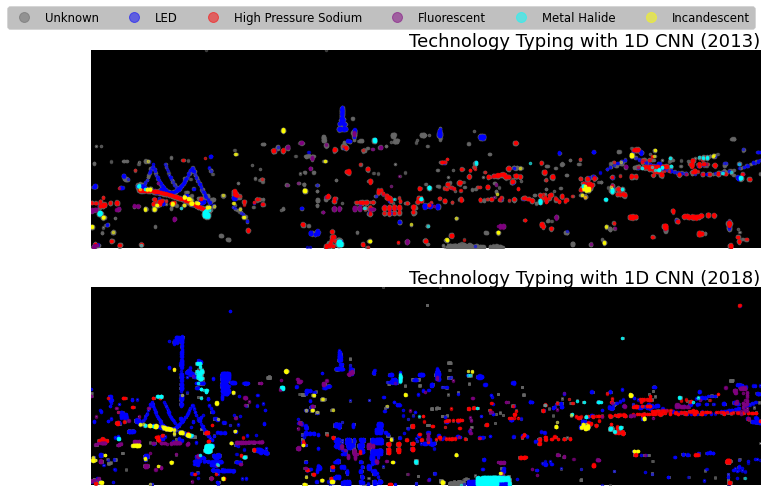

In [28]:
# -- imshoe the prediction
# -- this is for hsi0
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(unknown_hsi0.loc_x, unknown_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[0].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[0].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "red", label = 'High Pressure Sodium', alpha = 0.5)

ax[0].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "purple", label = 'Fluorescent', alpha = 0.5)
ax[0].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "cyan", label = 'Metal Halide', alpha = 0.5)
ax[0].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)
ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 11.69, facecolor = "silver", framealpha = 1)

ax[0].axis('off')
ax[0].set_facecolor("#444444")
ax[0].set_title("Technology Typing with 1D CNN (2013)", loc = "right", fontsize = 18)

# -- this is for hsi1
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].plot(unknown_hsi1.loc_x, unknown_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[1].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[1].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "red", label = 'High_pressure_sodium', alpha = 0.5)

ax[1].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "purple", label = 'Fluorescent', alpha = 0.5)
ax[1].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "cyan", label = 'Metal_Halide', alpha = 0.5)
ax[1].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

#ax.legend(markerscale=2, loc = "upper left")
ax[1].axis('off')

ax[1].set_title("Technology Typing with 1D CNN (2018)", loc = "right", fontsize = 18)

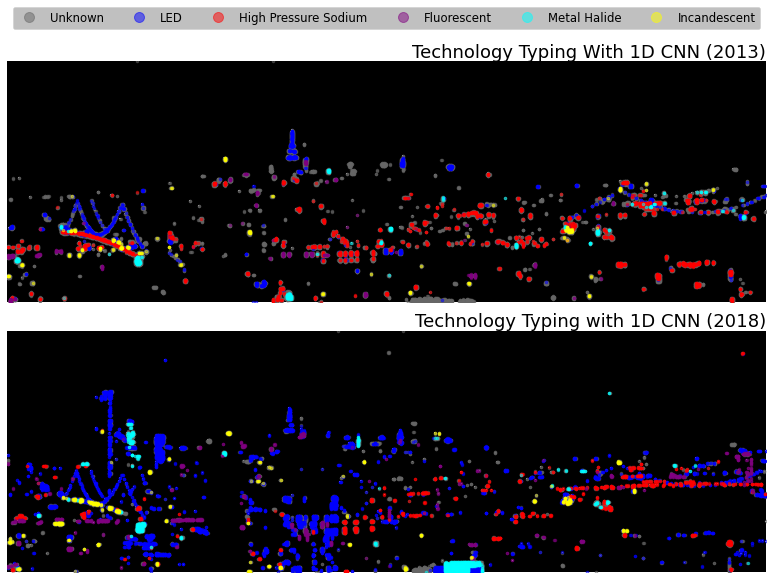

In [29]:
# -- imshoe the prediction
# -- this is for hsi0
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(unknown_hsi0.loc_x, unknown_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[0].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[0].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "red", label = 'High Pressure Sodium', alpha = 0.5)

ax[0].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "purple", label = 'Fluorescent', alpha = 0.5)
ax[0].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "cyan", label = 'Metal Halide', alpha = 0.5)
ax[0].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[0].axis('off')
ax[0].set_facecolor("#444444")
ax[0].set_title("Technology Typing With 1D CNN (2013)", loc = "right", fontsize = 18)

# rect2 = patches.Rectangle((130, 165), 95, 235, linewidth=4, edgecolor='none', facecolor='grey', zorder = 7, alpha = 0.8)
# ax[0].add_patch(rect2)
# rect = patches.Rectangle((320, 320), 155, 374, linewidth=4, edgecolor='none', facecolor='grey', zorder = 7, alpha = 0.8)
# ax[0].add_patch(rect)
# rect3 = patches.Rectangle((130, 165), 95, 235, linewidth=5, edgecolor='white', facecolor='none', zorder = 7, alpha = 0.8)
# ax[0].add_patch(rect3)
# rect4 = patches.Rectangle((320, 320), 155, 374, linewidth=5,edgecolor='white', facecolor='none', zorder = 7, alpha = 0.8)
# ax[0].add_patch(rect4)


# -- this is for hsi1
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].plot(unknown_hsi1.loc_x, unknown_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[1].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[1].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "red", label = 'High_pressure_sodium', alpha = 0.5)

ax[1].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "purple", label = 'Fluorescent', alpha = 0.5)
ax[1].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "cyan", label = 'Metal_Halide', alpha = 0.5)
ax[1].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)
# rect2 = patches.Rectangle((130, 165), 95, 235, linewidth=4, edgecolor='none', facecolor='grey', zorder = 7, alpha = 0.8)
# ax[1].add_patch(rect2)
# rect = patches.Rectangle((320, 320), 155, 374, linewidth=4,edgecolor='none', facecolor='grey', zorder = 7, alpha = 0.8)
# ax[1].add_patch(rect)
# #ax.legend(markerscale=2, loc = "upper left")
ax[1].axis('off')
# rect3 = patches.Rectangle((130, 165), 95, 235, linewidth=5, edgecolor='white', facecolor='none', zorder = 7, alpha = 0.8)
# ax[1].add_patch(rect3)
# rect4 = patches.Rectangle((320, 320), 155, 374, linewidth=5,edgecolor='white', facecolor='none', zorder = 7, alpha = 0.8)
# ax[1].add_patch(rect4)

ax[1].set_title("Technology Typing with 1D CNN (2018)", loc = "right", fontsize = 18)
fig.tight_layout()

In [80]:
plabs13 = np.load("../output/plabs13.npy")
loc13 = np.load("../output/loc13.npy")

In [131]:
HPS_x_2013_coef = loc13[(plabs13 == 0) | (plabs13 == 1), 1] 
HPS_y_2013_coef = loc13[(plabs13 == 0) | (plabs13 == 1), 0] 
LED_x_2013_coef = loc13[(plabs13 == 2) | (plabs13 == 3)| (plabs13 == 4) | (plabs13 == 5)| (plabs13 == 6) | (plabs13 == 7)|(plabs13 == 8) | (plabs13 == 9)| (plabs13 == 10) | (plabs13 == 11), 1] 
LED_y_2013_coef = loc13[(plabs13 == 2) | (plabs13 == 3)| (plabs13 == 4) | (plabs13 == 5)| (plabs13 == 6) | (plabs13 == 7)|(plabs13 == 8) | (plabs13 == 9)| (plabs13 == 10) | (plabs13 == 11), 0]
FLU_x_2013_coef = loc13[(plabs13 == 12) | (plabs13 == 13)|(plabs13 == 14) | (plabs13 == 15), 1]
FLU_y_2013_coef = loc13[(plabs13 == 12) | (plabs13 == 13)|(plabs13 == 14) | (plabs13 == 15), 0]
INC_x_2013_coef = loc13[(plabs13 == 16) | (plabs13 == 17), 1] 
INC_y_2013_coef = loc13[(plabs13 == 16) | (plabs13 == 17), 0] 
MHL_x_2013_coef = loc13[(plabs13 == 18) | (plabs13 == 19)| (plabs13 == 20)|(plabs13 == 21) | (plabs13 == 22) , 1] 
MHL_y_2013_coef = loc13[(plabs13 == 18) | (plabs13 == 19)| (plabs13 == 20)|(plabs13 == 21) | (plabs13 == 22), 0] 

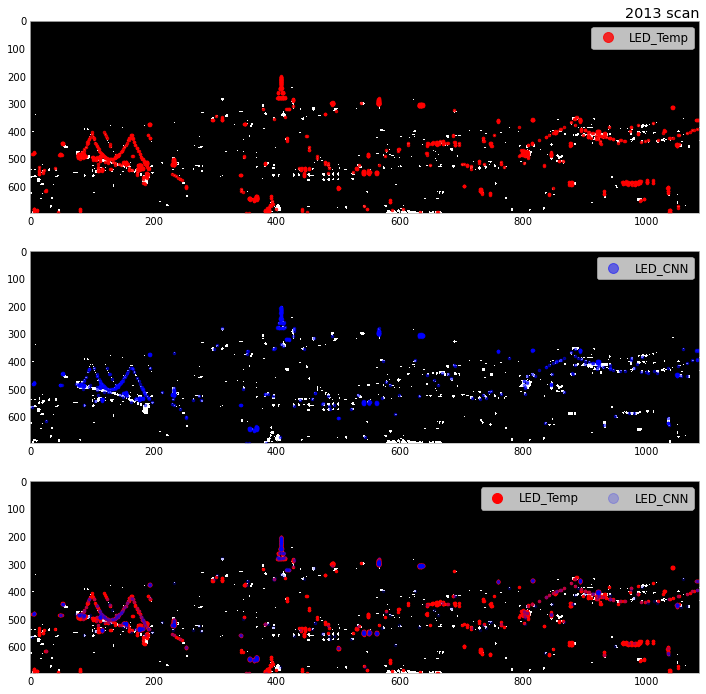

In [151]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (12, 12))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")
ax[2].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(LED_x_2013_coef, LED_y_2013_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'LED_Temp', alpha = 0.8)
ax[1].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED_CNN', alpha = 0.5)
ax[2].plot(LED_x_2013_coef, LED_y_2013_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'LED_Temp', alpha = 1.0)
ax[2].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED_CNN', alpha = 0.2)
ax[0].set_title("2013 scan", loc = "right")
ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[1].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[2].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=2, fontsize = 11.69, facecolor = "silver", framealpha = 1)


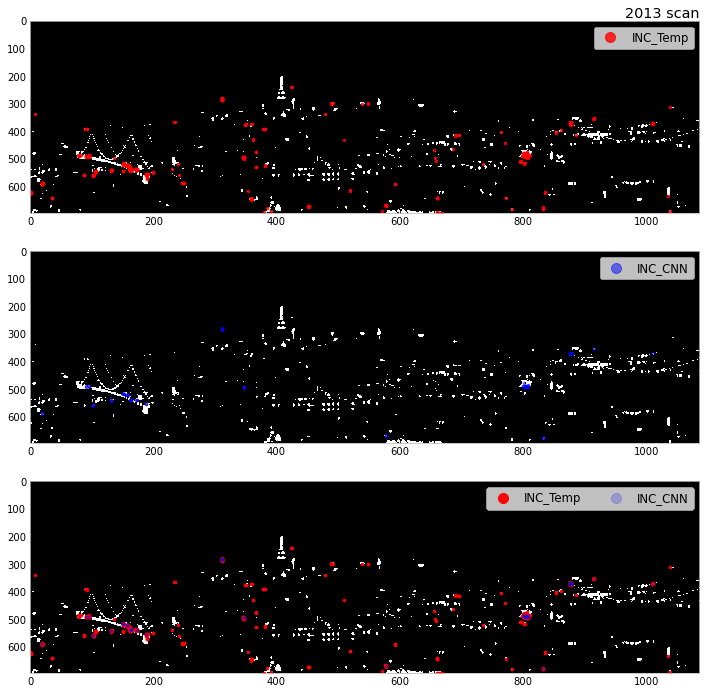

In [152]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (12, 12))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")
ax[2].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(INC_x_2013_coef, INC_y_2013_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'INC_Temp', alpha = 0.8)
ax[1].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'INC_CNN', alpha = 0.5)
ax[2].plot(INC_x_2013_coef, INC_y_2013_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'INC_Temp', alpha = 1.0)
ax[2].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'INC_CNN', alpha = 0.2)
ax[0].set_title("2013 scan", loc = "right")

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[1].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[2].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=2, fontsize = 11.69, facecolor = "silver", framealpha = 1)


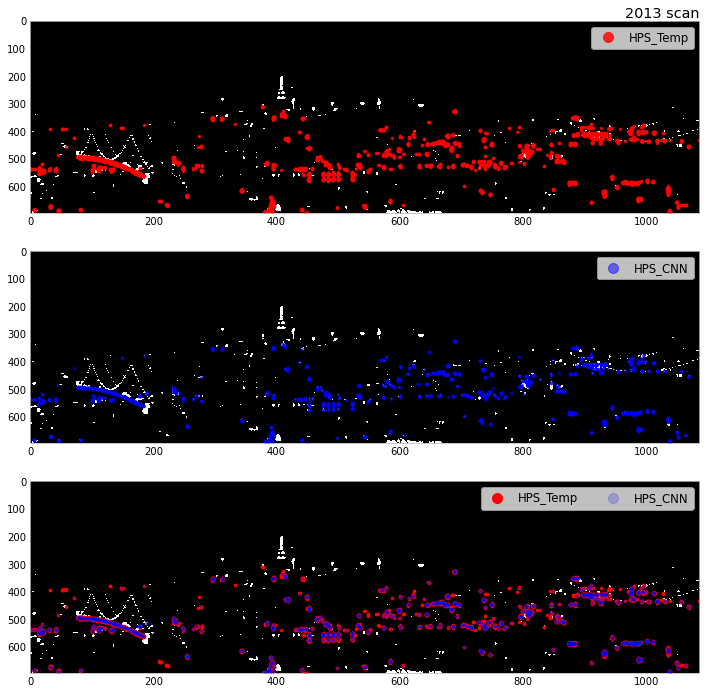

In [153]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (12, 12))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")
ax[2].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(HPS_x_2013_coef, HPS_y_2013_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'HPS_Temp', alpha = 0.8)
ax[1].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'HPS_CNN', alpha = 0.5)
ax[2].plot(HPS_x_2013_coef, HPS_y_2013_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'HPS_Temp', alpha = 1.0)
ax[2].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'HPS_CNN', alpha = 0.2)
ax[0].set_title("2013 scan", loc = "right")

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[1].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[2].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=2, fontsize = 11.69, facecolor = "silver", framealpha = 1)


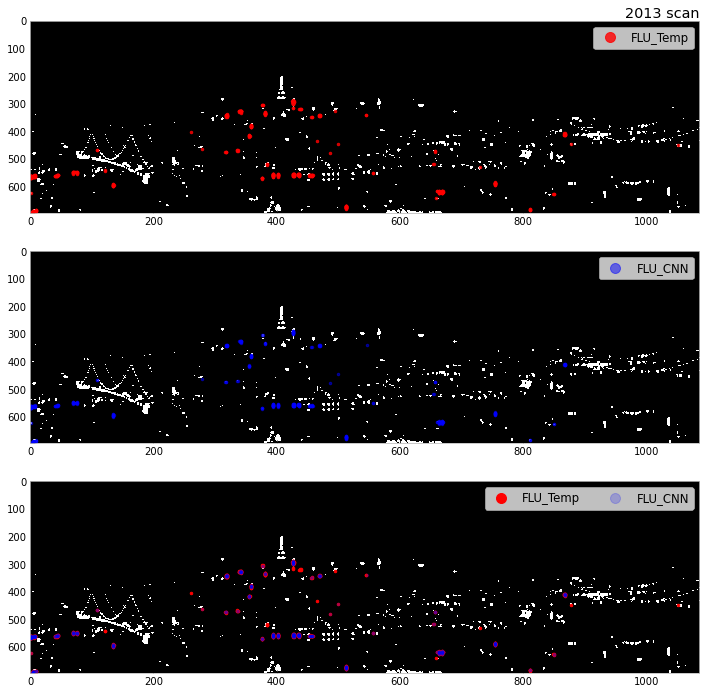

In [154]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (12, 12))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")
ax[2].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(FLU_x_2013_coef, FLU_y_2013_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'FLU_Temp', alpha = 0.8)
ax[1].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'FLU_CNN', alpha = 0.5)
ax[2].plot(FLU_x_2013_coef, FLU_y_2013_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'FLU_Temp', alpha = 1)
ax[2].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'FLU_CNN', alpha = 0.2)
ax[0].set_title("2013 scan", loc = "right")

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[1].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[2].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=2, fontsize = 11.69, facecolor = "silver", framealpha = 1)


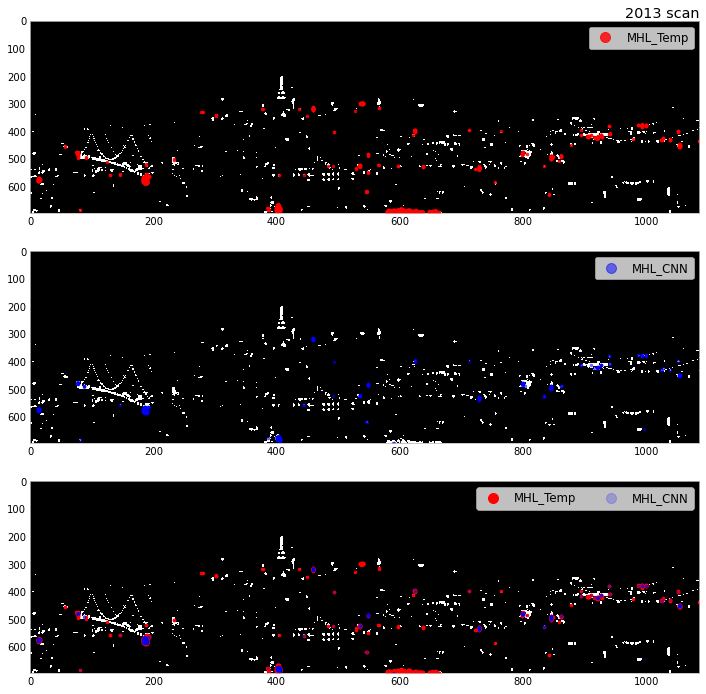

In [155]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (12, 12))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")
ax[2].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(MHL_x_2013_coef, MHL_y_2013_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'MHL_Temp', alpha = 0.8)
ax[1].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'MHL_CNN', alpha = 0.5)
ax[2].plot(MHL_x_2013_coef, MHL_y_2013_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'MHL_Temp', alpha = 1)
ax[2].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'MHL_CNN', alpha = 0.2)
ax[0].set_title("2013 scan", loc = "right")

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[1].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[2].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=2, fontsize = 11.69, facecolor = "silver", framealpha = 1)

In [143]:
plabs18 = np.load("../output/plabs18.npy")
loc18 = np.load("../output/loc18.npy")

In [144]:
HPS_x_2018_coef = loc18[(plabs18 == 0) | (plabs18 == 1), 1] 
HPS_y_2018_coef = loc18[(plabs18 == 0) | (plabs18 == 1), 0] 
LED_x_2018_coef = loc18[(plabs18 == 2) | (plabs18 == 3)| (plabs18 == 4) | (plabs18 == 5)| (plabs18 == 6) | (plabs18 == 7)|(plabs18 == 8) | (plabs18 == 9)| (plabs18 == 10) | (plabs18 == 11), 1] 
LED_y_2018_coef = loc18[(plabs18 == 2) | (plabs18 == 3)| (plabs18 == 4) | (plabs18 == 5)| (plabs18 == 6) | (plabs18 == 7)|(plabs18 == 8) | (plabs18 == 9)| (plabs18 == 10) | (plabs18 == 11), 0]
FLU_x_2018_coef = loc18[(plabs18 == 12) | (plabs18 == 13)|(plabs18 == 14) | (plabs18 == 15), 1]
FLU_y_2018_coef = loc18[(plabs18 == 12) | (plabs18 == 13)|(plabs18 == 14) | (plabs18 == 15), 0]
INC_x_2018_coef = loc18[(plabs18 == 16) | (plabs18 == 17), 1] 
INC_y_2018_coef = loc18[(plabs18 == 16) | (plabs18 == 17), 0] 
MHL_x_2018_coef = loc18[(plabs18 == 18) | (plabs18 == 19)| (plabs18 == 20)|(plabs18 == 21) | (plabs18 == 22) , 1] 
MHL_y_2018_coef = loc18[(plabs18 == 18) | (plabs18 == 19)| (plabs18 == 20)|(plabs18 == 21) | (plabs18 == 22), 0] 

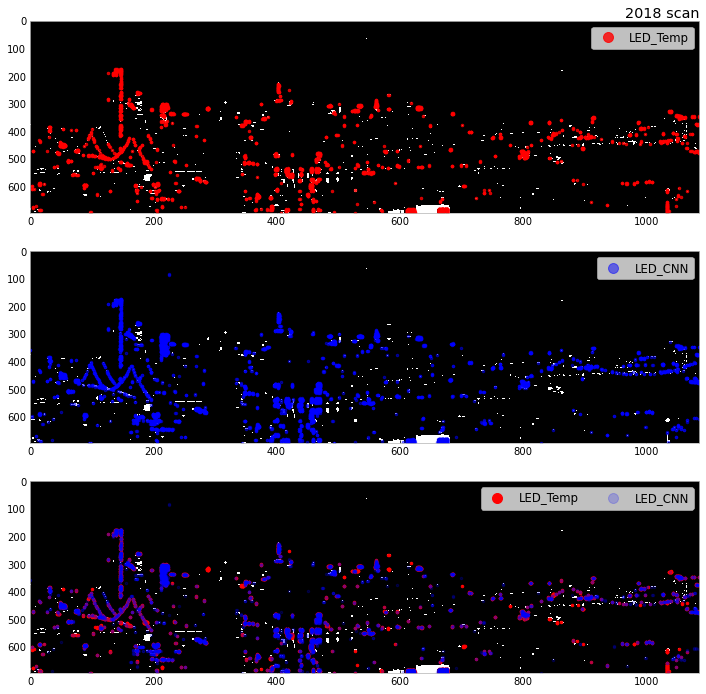

In [156]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (12, 12))
ax[0].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[2].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(LED_x_2018_coef, LED_y_2018_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'LED_Temp', alpha = 0.8)
ax[1].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED_CNN', alpha = 0.5)
ax[2].plot(LED_x_2018_coef, LED_y_2018_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'LED_Temp', alpha = 1.0)
ax[2].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'LED_CNN', alpha = 0.2)
ax[0].set_title("2018 scan", loc = "right")

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[1].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[2].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=2, fontsize = 11.69, facecolor = "silver", framealpha = 1)

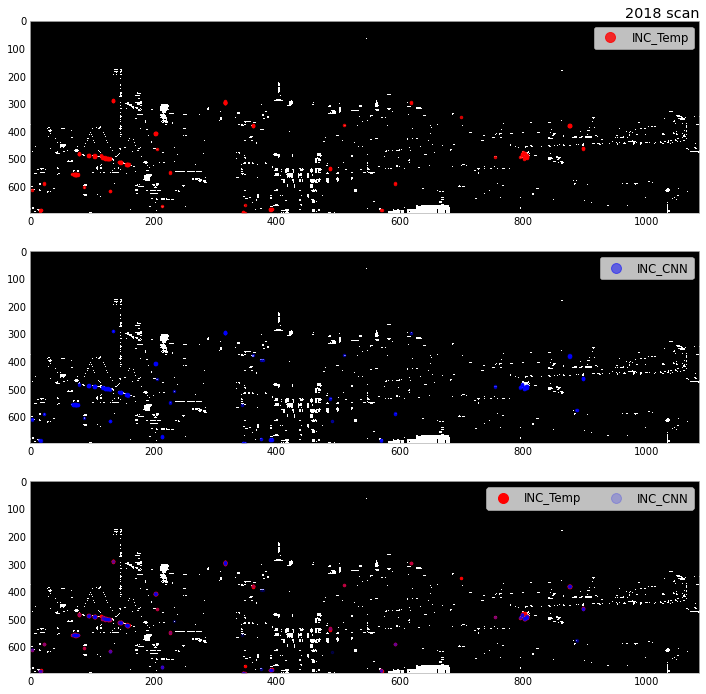

In [157]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (12, 12))
ax[0].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[2].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(INC_x_2018_coef, INC_y_2018_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'INC_Temp', alpha = 0.8)
ax[1].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'INC_CNN', alpha = 0.5)
ax[2].plot(INC_x_2018_coef, INC_y_2018_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'INC_Temp', alpha = 1.0)
ax[2].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'INC_CNN', alpha = 0.2)
ax[0].set_title("2018 scan", loc = "right")

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[1].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[2].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=2, fontsize = 11.69, facecolor = "silver", framealpha = 1)


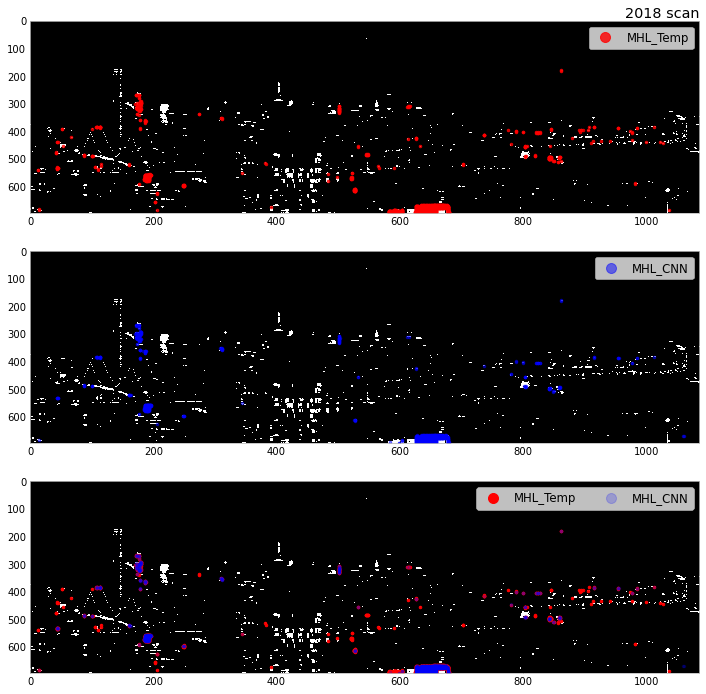

In [158]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (12, 12))
ax[0].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[2].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(MHL_x_2018_coef, MHL_y_2018_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'MHL_Temp', alpha = 0.8)
ax[1].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'MHL_CNN', alpha = 0.5)
ax[2].plot(MHL_x_2018_coef, MHL_y_2018_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'MHL_Temp', alpha = 1)
ax[2].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'MHL_CNN', alpha = 0.2)
ax[0].set_title("2018 scan", loc = "right")

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[1].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[2].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=2, fontsize = 11.69, facecolor = "silver", framealpha = 1)

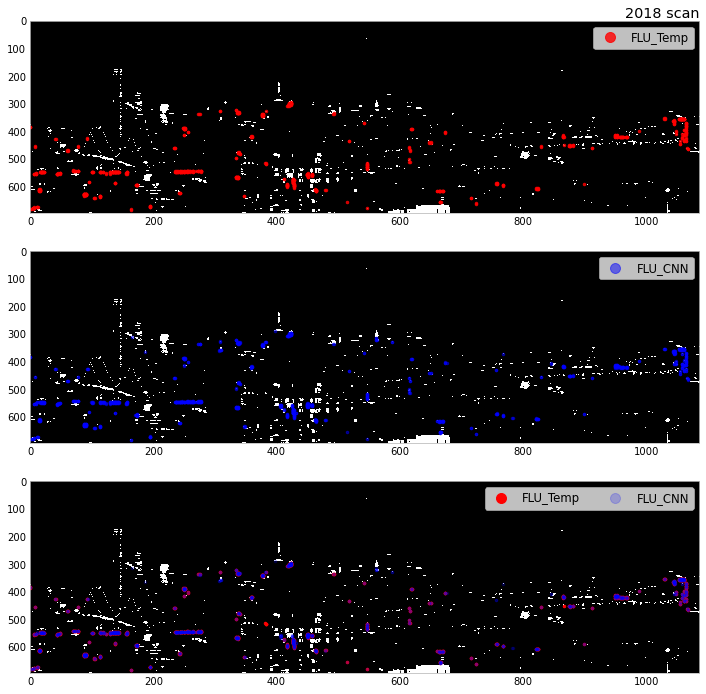

In [159]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (12, 12))
ax[0].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[2].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(FLU_x_2018_coef, FLU_y_2018_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'FLU_Temp', alpha = 0.8)
ax[1].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'FLU_CNN', alpha = 0.5)
ax[2].plot(FLU_x_2018_coef, FLU_y_2018_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'FLU_Temp', alpha = 1)
ax[2].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'FLU_CNN', alpha = 0.2)
ax[0].set_title("2018 scan", loc = "right")

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[1].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[2].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=2, fontsize = 11.69, facecolor = "silver", framealpha = 1)


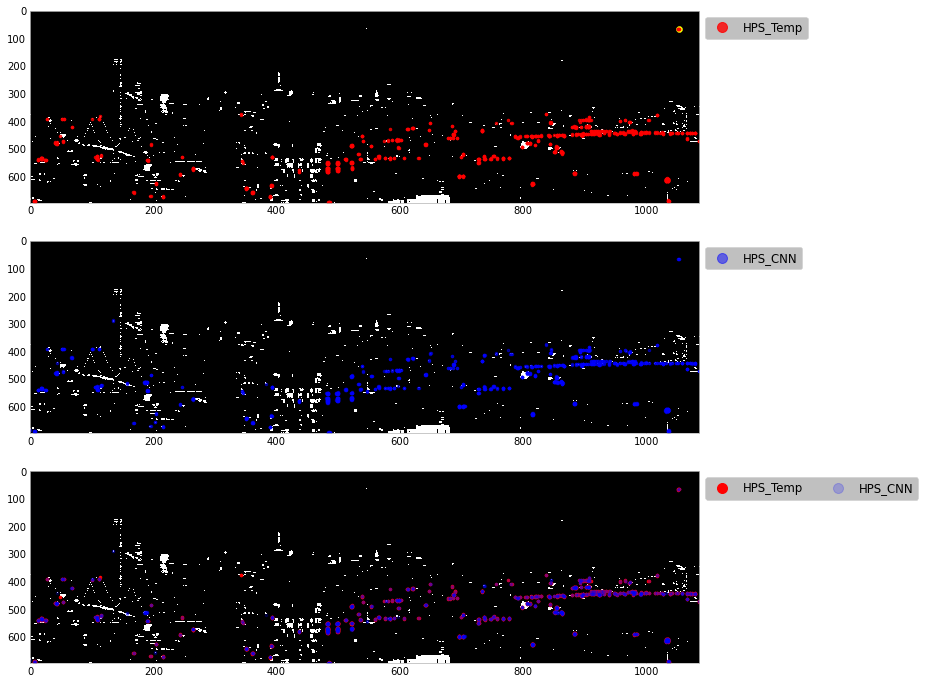

In [172]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (12, 12))
ax[0].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[2].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(HPS_x_2018_coef, HPS_y_2018_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'HPS_Temp', alpha = 0.8)
ax[1].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'HPS_CNN', alpha = 0.5)
ax[2].plot(HPS_x_2018_coef, HPS_y_2018_coef, marker="o", linestyle='', ms=2.5, c = "red", label = 'HPS_Temp', alpha = 1.0)
ax[2].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker="o", linestyle='', ms=2.5, c = "blue", label = 'HPS_CNN', alpha = 0.2)
# ax[0].scatter(1053, 63, marker = "o", c = "yellow")
ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[1].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=1, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[2].legend(markerscale=4, bbox_to_anchor=(1, 1), ncol=2, fontsize = 11.69, facecolor = "silver", framealpha = 1)


In [161]:
imgL_hsi1_half0 = np.load("../output/filtered_hsi1_half0.npy")
imgL_hsi1_half1 = np.load("../output/filtered_hsi1_half1.npy")
hsi1 = np.hstack([imgL_hsi1_half0, imgL_hsi1_half1])

In [165]:
from scipy.ndimage import zoom


In [167]:
img_L1_rs = zoom(hsi1[, np.divide((695, 1252), (1600, 3195)), order = 1)
1053

SyntaxError: invalid syntax (1587051851.py, line 1)

In [170]:
HPS_hsi1[HPS_hsi1.loc_y < 90]

,pred,loc_x,loc_y
7,High_Pressure_Sodium,1053,63
8,High_Pressure_Sodium,1052,64
9,High_Pressure_Sodium,1053,64
10,High_Pressure_Sodium,1052,65


In [173]:
x = 1053
y = 63

In [181]:
1600 * 63 /695

145.0359712230216

In [182]:
3195 * (1053+ 165) /1252

3108.23482428115

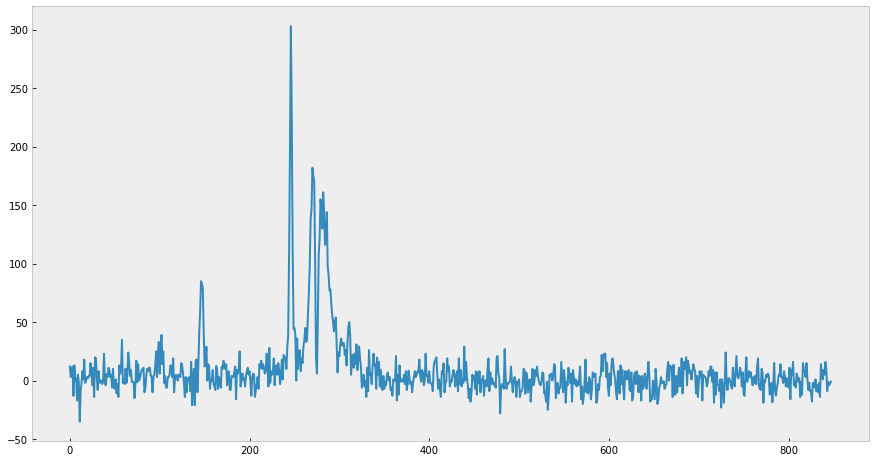

In [185]:
plt.plot(hsi1[:, 145, 3108])